We bring the imports we need

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

## Load dataset

We will use yfincance to get the data from #Microsoft#

In [48]:
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download("MSFT", start, end)
dataset.shape

[*********************100%%**********************]  1 of 1 completed


(2014, 6)

## Inspect dataset

Let's see the dataset that we have

In [49]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-14,420.239990,427.820007,417.989990,425.220001,425.220001,34157300
2024-03-15,419.290009,422.600006,412.790009,416.420013,416.420013,45049800
2024-03-18,414.250000,420.730011,413.779999,417.320007,417.320007,20106000
2024-03-19,417.829987,421.670013,415.549988,421.410004,421.410004,19824100
2024-03-20,422.250000,423.230011,420.660004,423.089996,423.089996,5625443


Let's check for null data

In [50]:
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

We will check what type of data are the columns from dataset

In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2016-03-21 to 2024-03-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2014 non-null   float64
 1   High       2014 non-null   float64
 2   Low        2014 non-null   float64
 3   Close      2014 non-null   float64
 4   Adj Close  2014 non-null   float64
 5   Volume     2014 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.1 KB


Let's check for duplicates

In [52]:
dataset.duplicated().sum()

0

Let's observe the dataset in a plot

c:\Users\tudoropris\miniconda3\envs\stock-prediction-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tudoropris\miniconda3\envs\stock-prediction-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


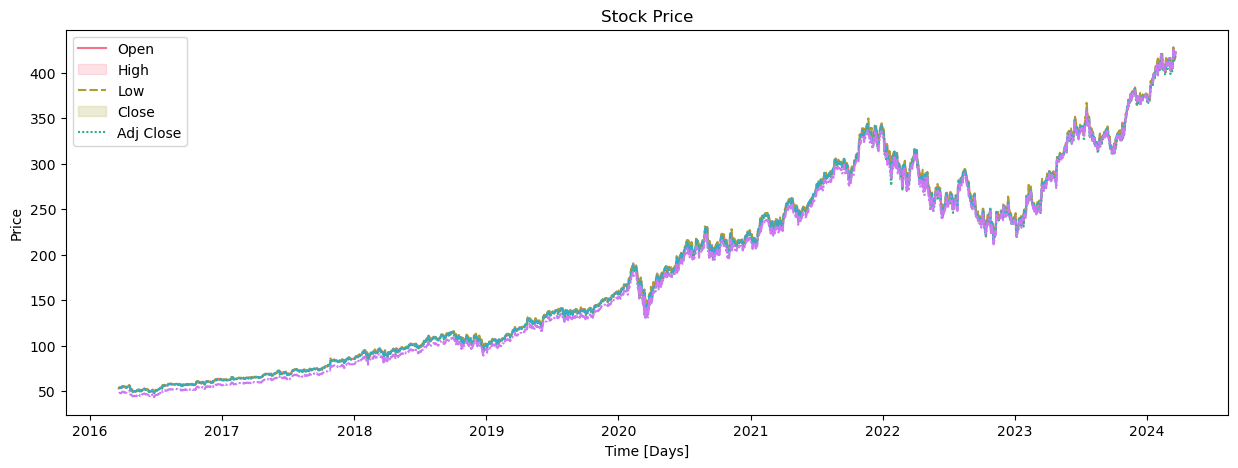

In [53]:
plt.figure(figsize=(15, 5))
palette = sns.color_palette("husl", 5)
sns.lineplot(data=dataset[['Open', 'High', 'Low', 'Close', 'Adj Close']],palette=palette) 
plt.title('Stock Price')
plt.xlabel('Time [Days]')
plt.ylabel('Price')
plt.legend(labels=['Open', 'High', 'Low', 'Close', 'Adj Close'], loc='best')
plt.show()

In [54]:
original_dataset = dataset

## Transform the data

We normalize the data

In [55]:
scaler = MinMaxScaler()
columns_to_normalize = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
dataset[columns_to_normalize] = scaler.fit_transform(dataset[columns_to_normalize])

dataset.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-21,0.011598,0.012623,0.013123,53.860001,0.011918,0.143108
2016-03-22,0.012563,0.013468,0.014546,54.070000,0.012410,0.136839
2016-03-23,0.013902,0.013442,0.015297,53.970001,0.012175,0.113418
2016-03-24,0.013179,0.013679,0.015270,54.209999,0.012737,0.112018
2016-03-28,0.014170,0.013574,0.014197,53.540001,0.011169,0.089145


In [56]:
close_scaler = MinMaxScaler()
columns_to_normalize = ['Close']
dataset[columns_to_normalize] = close_scaler.fit_transform(dataset[columns_to_normalize])


Splitting the data

In [57]:
X = dataset[['Open', 'High', 'Low', 'Adj Close']]
y = dataset[['Close']]


X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=False)

In [58]:
def create_time_steps(data, time_steps):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps])
        y.append(data.iloc[i+time_steps])
    return np.array(X), np.array(y)

# Define the number of time steps
time_steps = 10

# Create time steps sequences for training data
X_train_seq, y_train_seq = create_time_steps(X_train, time_steps)

# Create time steps sequences for validation data
X_val_seq, y_val_seq = create_time_steps(X_val, time_steps)

# Create time steps sequences for test data
X_test_seq, y_test_seq = create_time_steps(X_test, time_steps)

## Create Model RNN Sequential LSTM

In [59]:
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(time_steps , 4)),
    Dense(units=1)  # Output layer for regression task
])

In [60]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [61]:
history = model.fit(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq))


Epoch 1/50
51/51 [==============================] - 1s 8ms/step - loss: 0.0163 - val_loss: 4.0874e-04
Epoch 2/50
51/51 [==============================] - 0s 4ms/step - loss: 1.8991e-04 - val_loss: 3.8273e-04
Epoch 3/50
51/51 [==============================] - 0s 4ms/step - loss: 1.5590e-04 - val_loss: 3.6380e-04
Epoch 4/50
51/51 [==============================] - 0s 4ms/step - loss: 1.4740e-04 - val_loss: 3.5967e-04
Epoch 5/50
51/51 [==============================] - 0s 4ms/step - loss: 1.3873e-04 - val_loss: 3.7698e-04
Epoch 6/50
51/51 [==============================] - 0s 4ms/step - loss: 1.3610e-04 - val_loss: 4.7098e-04
Epoch 7/50
51/51 [==============================] - 0s 4ms/step - loss: 1.5404e-04 - val_loss: 3.6614e-04
Epoch 8/50
51/51 [==============================] - 0s 4ms/step - loss: 1.3173e-04 - val_loss: 3.4563e-04
Epoch 9/50
51/51 [==============================] - 0s 4ms/step - loss: 1.2719e-04 - val_loss: 3.2795e-04
Epoch 10/50
51/51 [==============================]

In [62]:
validation_prediction=model.predict(X_val_seq)
test_predict=model.predict(X_test_seq)

6/6 [==============================] - 0s 2ms/step


In [63]:
y_valid_inversed = close_scaler.inverse_transform(validation_prediction)
y_test_inversed = close_scaler.inverse_transform(test_predict)

In [65]:
y_test_original = close_scaler.inverse_transform(y_test)

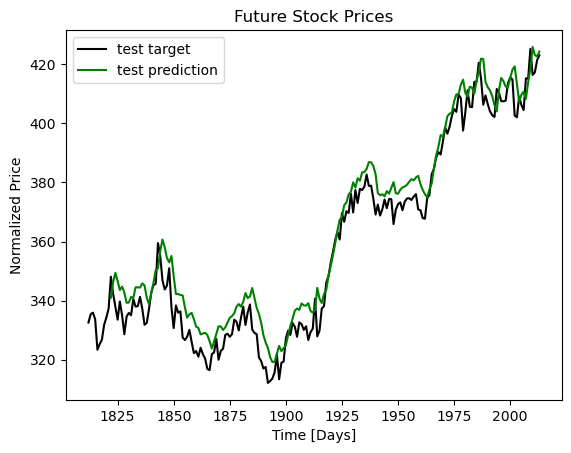

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined y_train, y_test, validation_prediction, and test_predict

# Calculate the starting index for test data in the x-axis
start_index = y_train.shape[0] + y_val.shape[0]
end_index_first_plot = start_index + y_test.shape[0]
x_values_second_plot = np.arange(end_index_first_plot - test_predict.shape[0], end_index_first_plot)


# Plotting
plt.plot(np.arange(start_index, start_index + y_test.shape[0]),
         y_test_original, color='black', label='test target')

plt.plot(x_values_second_plot,
         y_test_inversed, color='green', label='test prediction')

plt.title('Future Stock Prices')
plt.xlabel('Time [Days]')
plt.ylabel('Normalized Price')
plt.legend(loc='best')

plt.show()
